In [3]:
import os
from dotenv import load_dotenv

from sdk.gnn_table import GNNTable, ForeignKey
from sdk.types import ColumnDType
from sdk.metrics import EvaluationMetric
from sdk.task import LinkTask, TaskType
from sdk.dataset import Dataset
from sdk.config_trainer import TrainerConfig
from sdk.trainer import Trainer
from sdk.connector import SnowflakeConnector
from common.export import OutputConfig, SnowflakeSettings
from IPython.display import Image, display

# Load Environment Variables
load_dotenv()

# Jupyter Magic Commands
%load_ext autoreload
%load_ext jupyter_black
%autoreload 2

### 1. Setup snowflake connection and input data

In [26]:
app_endpoint = "https://f5d4y5qc-ndsoebe-rai-gnns-test.snowflakecomputing.app"
mlflow_endpoint = "https://n5d4y5qc-ndsoebe-rai-gnns-test.snowflakecomputing.app"
sdk_endpoint = "https://j5d4y5qc-ndsoebe-rai-gnns-test.snowflakecomputing.app"

In [27]:
print(os.getenv("ACCOUNT_NAME"))
connector = SnowflakeConnector(
    endpoint_url=sdk_endpoint,
    account=os.getenv("ACCOUNT_NAME"),
    user=os.getenv("USER_NAME"),
    password=os.getenv("PASSWORD"),
)

ndsoebe-rai-gnns-test


In [6]:
buyers_pth = "GNN_DEMO_TF.TF_DATA.BUYERS"
senders_pth = "GNN_DEMO_TF.TF_DATA.SENDERS"
transactions_pth = "GNN_DEMO_TF.TF_DATA.TRANSACTIONS"
train_pth = "GNN_DEMO_TF.TF_LINK_PRED.TRAIN"
val_pth = "GNN_DEMO_TF.TF_LINK_PRED.VAL"
test_pth = "GNN_DEMO_TF.TF_LINK_PRED.TEST"

### Create GNN Tables (Graph Initialization)

We create three different tables, a table for the buyers a table
for the senders and a table with the transactions between them

In [7]:
buyers_table = GNNTable(
    connector=connector,
    source=buyers_pth,
    name="buyers",
    primary_key="BUY_TOKEN_ADDRESS",
)
buyers_table.show_table()


Table: buyers
Source: GNN_DEMO_TF.TF_DATA.BUYERS

Columns:
+-------------------+-------------+-------------+----------+-----------+
| Column Name       | Data Type   | Key Type    | Format   | Link To   |
+===================+=============+=============+==========+===========+
| BUY_TOKEN_ADDRESS | text        | primary_key |          |           |
+-------------------+-------------+-------------+----------+-----------+
None


In [8]:
senders_table = GNNTable(
    connector=connector,
    source=senders_pth,
    name="senders",
    primary_key="TX_SENDER_ADDRESS",
)
senders_table.show_table()


Table: senders
Source: GNN_DEMO_TF.TF_DATA.SENDERS

Columns:
+-------------------+-------------+-------------+----------+-----------+
| Column Name       | Data Type   | Key Type    | Format   | Link To   |
+===================+=============+=============+==========+===========+
| TX_SENDER_ADDRESS | text        | primary_key |          |           |
+-------------------+-------------+-------------+----------+-----------+
None


In [9]:
transactions_table = GNNTable(
    connector=connector,
    source=transactions_pth,
    name="transactions",
    foreign_keys=[
        ForeignKey(
            column_name="TX_SENDER_ADDRESS", link_to="senders.TX_SENDER_ADDRESS"
        ),
        ForeignKey(column_name="BUY_TOKEN_ADDRESS", link_to="buyers.BUY_TOKEN_ADDRESS"),
    ],
    time_column="BLOCK_TIMESTAMP",
)
# modify column dtypes if needed
transactions_table.update_column_dtype(
    col_name="BUY_AMOUNT", dtype=ColumnDType.integer_t
)
transactions_table.update_column_dtype(
    col_name="SELL_AMOUNT", dtype=ColumnDType.integer_t
)
transactions_table.show_table()


Table: transactions
Source: GNN_DEMO_TF.TF_DATA.TRANSACTIONS
Time Column: BLOCK_TIMESTAMP

Columns:
+-------------------+-------------+-------------+----------+---------------------------+
| Column Name       | Data Type   | Key Type    | Format   | Link To                   |
+===================+=============+=============+==========+===========================+
| TX_SENDER_ADDRESS | text        | foreign_key |          | senders.TX_SENDER_ADDRESS |
+-------------------+-------------+-------------+----------+---------------------------+
| BUY_TOKEN_ADDRESS | text        | foreign_key |          | buyers.BUY_TOKEN_ADDRESS  |
+-------------------+-------------+-------------+----------+---------------------------+
| BLOCK_TIMESTAMP   | datetime    |             |          |                           |
+-------------------+-------------+-------------+----------+---------------------------+
| BUY_AMOUNT        | integer     |             |          |                           |
+--------

### Preparing the link prediction task

In [10]:
# our task is a classic link prediction task,
# we will predict if there exists an edge between
# senders and buyers.

link_pred_task = LinkTask(
    connector=connector,
    name="link_prediction_example",
    task_data_source={"train": train_pth, "test": test_pth, "validation": val_pth},
    source_entity_column="TX_SENDER_ADDRESS",
    source_entity_table="senders",
    target_entity_column="BUY_TOKEN_ADDRESS",
    targer_entity_table="buyers",
    task_type=TaskType.LINK_PREDICTION,
    time_column="BLOCK_TIMESTAMP",
    evaluation_metric=EvaluationMetric(name="link_prediction_map", eval_at_k=10),
)
link_pred_task.show_task()

Task Information
Task name:      link_prediction_example
Task type:      link_prediction

Task Table Sources:
--------------------------------------------------
  • train: GNN_DEMO_TF.TF_LINK_PRED.TRAIN
  • test: GNN_DEMO_TF.TF_LINK_PRED.TEST
  • validation: GNN_DEMO_TF.TF_LINK_PRED.VAL

Entity Information:
--------------------------------------------------
  • Target entity column: BUY_TOKEN_ADDRESS
  • Target entity table:  buyers
  • Source entity column: TX_SENDER_ADDRESS
  • Source entity table:  senders

Time Information:
--------------------------------------------------
  • Time column: BLOCK_TIMESTAMP

Evaluation:
--------------------------------------------------
  • Metric: name='link_prediction_map' eval_at_k=10

Table Schema:
--------------------------------------------------

Table: link_prediction_example
Source: GNN_DEMO_TF.TF_LINK_PRED.TRAIN
Time Column: BLOCK_TIMESTAMP

Columns:
+-------------------+-------------+-------------+----------+---------------------------+
|

### Putting it all together (dataset creation)

In [11]:
dataset = Dataset(
    connector=connector,
    dataset_name="tokenflow",
    tables=[buyers_table, transactions_table, senders_table],
    task_description=link_pred_task,
)

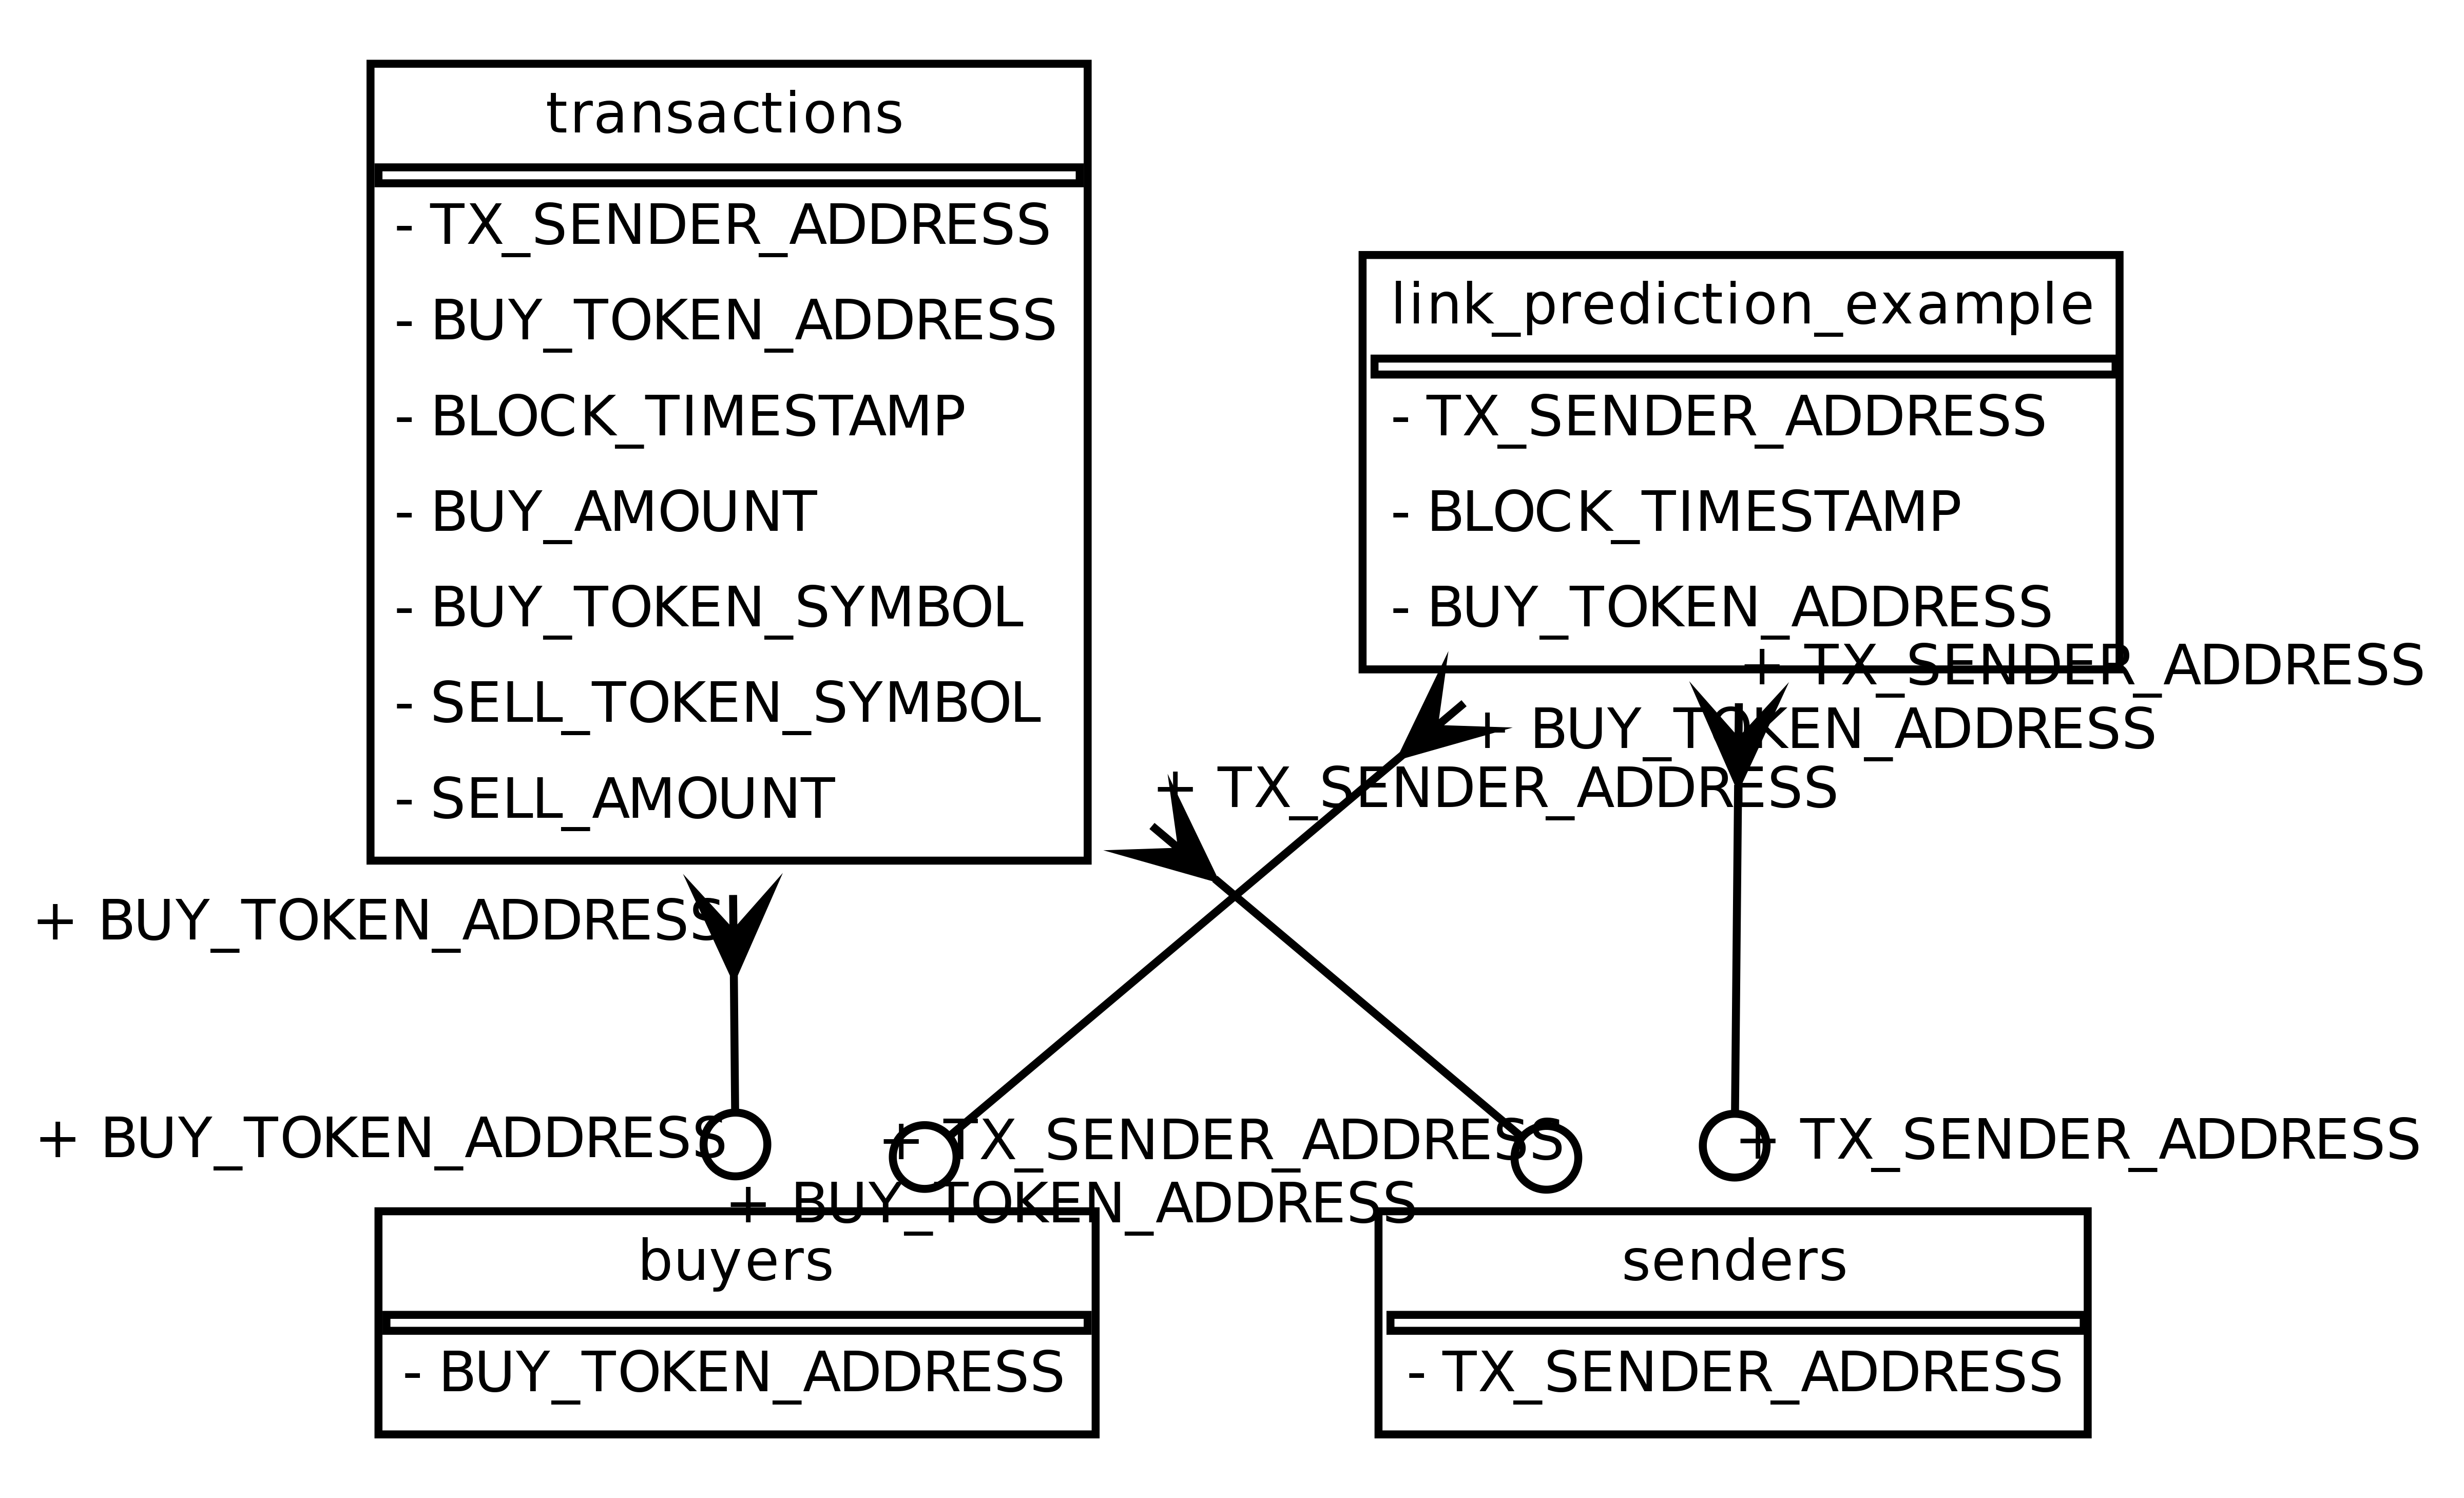

In [12]:
graph = dataset.visualize_dataset(show_dtypes=False)
graph.set_graph_defaults(size="50,50!")  # Increase graph size
plt = Image(graph.create_png(), width=600, height=600)
display(plt)

### Train a GNN on the link prediction task

In [35]:
# create the GNN model configuration
train_config = TrainerConfig(
    connector=connector,
    device="cuda",
    n_epochs=2,
    id_awareness=True,
    temporal_strategy="last",
    max_iters=2000,
    train_batch_size=128,
    shallow_embeddings_list=["buyers"],
    share_same_time=False,
)
# initialize the Trainer
trainer = Trainer(connector=connector, config=train_config)

In [ ]:
# create a couple of training jons that we will use for inference
train_job_1 = trainer.fit(dataset=dataset)


In [38]:
train_job_1.get_status()

{
  "job_id": "81740511-68e9-46f7-b83f-ac9d34f0d2ed",
  "status": "COMPLETED",
  "started_at": "2025-04-15T15:25:39.343194",
  "finished_at": "2025-04-15T15:26:33.993802",
  "updated_at": "2025-04-15T15:26:33.993806",
  "job_type": "train",
  "model_run_id": "155e01db9fdc446494b5fd234402402c",
  "result": {
    "metrics": {
      "1": {
        "train_loss": 0.05695753008661213,
        "val_metrics": {
          "link_prediction_precision": 0.11436170212765957,
          "link_prediction_recall": 0.16049389222066088,
          "link_prediction_map": 0.13280835627466833
        },
        "tune_metric": "link_prediction_map",
        "learning_rate": 0.0005000050000000001
      },
      "2": {
        "train_loss": 0.037714523783767336,
        "val_metrics": {
          "link_prediction_precision": 0.11170212765957445,
          "link_prediction_recall": 0.1695959597585137,
          "link_prediction_map": 0.10414565487703785
        },
        "tune_metric": "link_prediction_map",
  

# Run Inference

In [40]:
output_config = OutputConfig.snowflake(
    database_name="GNN_DEMO_TF", schema_name="PUBLIC"
)

inference_job = trainer.predict(
    output_alias="EXP_1",
    output_config=output_config,
    dataset=dataset,
    test_batch_size=128,
    model_run_id=train_job_1.model_run_id,
)

In [43]:
inference_job.get_status()

{
  "job_id": "20c581df-e04d-4662-9075-918e3c9ad4f3",
  "status": "COMPLETED",
  "started_at": "2025-04-15T15:29:18.582832",
  "finished_at": "2025-04-15T15:29:29.572703",
  "updated_at": "2025-04-15T15:29:29.572707",
  "job_type": "inference"
}
